# [개념 필사]

# CHAPTER 07 <군집화>

## 05. DBSCAN

> DBSCAN: 밀도 기반 군집화. 기하학적으로 복잡한 분포의 데이터세트에 효과적.

* 입실론 주변 영역: 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역

* 최소 데이터 개수: 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터 개수

* 특정 핵심 포인트에서 직접 접근 가능한 다른 핵심 포인트를 서로 연결하면서 군집화 구성

**입실론 주변 영역 내 최소 데이터 개수 충족 여부**

* 핵심포인트: 최소 데이터 개수 이상
* 이웃포인트: 주변 영역 내에 위치한 타 데이터
* 경계포인트: 핵심포인트는 아니나, 핵심포인트가 이웃포인트. 군집의 외곽 형성.
* 잡음포인트: 핵심포인트도 아니고 경계포인트도 아님.


```
BDSCAN 사이킷런 클래스

eps: 입실론 주변 영역 반경. 보통 1 이하로 설정. 클수록 노이즈 데이터 개수는 감소.

min_samples: 핵심포인트가 되기 위해 필요한 최소 데이터 개수. 자신 포함. 클수록 노이즈 데이터 개수 증가.
```

* 군집 레이블 -1: 노이즈에 속하는 군집

* 특정 군집 개수를 강제하지 않는 것이 좋음.


```
make_circles(): 내부원&외부원 형태의 2차원 데이터 세트 생성 함수. 오직 2개의 피처만 생성

noise: 노이즈 데이터 세트 비율

factor: 외부 원과 내부 원의 scale 비율
```

## 06. 군집화 실습 - 고객 세그먼테이션

> 고객 세그먼테이션: 다양한 기준으로 고객을 분류하는 기법

* 중요한 분류 요소: 어떤 상품을 얼마나 많은 비용을 써서 얼마나 자주 사용하는가. 매출 중요.

* 목표: 타깃 마케팅 (고객 유형에 따라 맞춤형 마케팅, 서비스를 제공하는 것)

* RFM 기법

  -- Recency: 가장 최근 상품 구입 일에서 오늘까지의 기간

  -- Frequency: 상품 구매 횟수

  -- Monetary Value: 총 구매 금액

> 고객 세그먼트 군집화 적용

* 데이터 세트: Online Retail

* 칼럼

  -- InvoiceNo： 주문번호 ‘C’로 시작하는 것은 취소 주문

  -- StockCode： 제품 코드（Item Code）

  -- Description： 제품 설명

  -- Quantity： 주문 제품 건수

  -- InvoiceDate： 주문 일자

  -- UnitPrice： 제품 단가

  -- CustomerlD： 고객 번호

  -- Country： 국가명（주문고객의국적）


* CustomerlD 결측 데이터 삭제, 오류 데이터 삭제 - 불린 인덱싱 사용

* 영국 외의 국가 데이터 삭제

> RFM 기반 데이터 가공

* sale_amount = Quantity * UnitPrice

* CustomerlD -> int 형으로 변경

* InvoiceNo + StockCode 기준 데이터를 고객 기준의 R,F,M 데이터로 변경.

> RFM 기반 고객 세그먼테이션

* 지나치게 왜곡된 데이터세트에 K-평균 적용 시, 지나치게 일반적인 군집화 결과 도출

* 왜곡 정도 낮추기 위해 로그변환 수행.


# [코드 필사]

* 붓꽃 데이터 BDSCAN 적용

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 편리한 데이터 핸들링을 위해 DaraFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [2]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


In [3]:
# 군집 수행 시각화 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

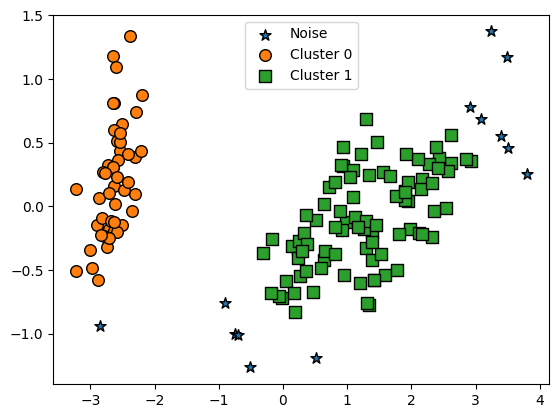

In [4]:
from sklearn.decomposition import PCA
# 2차원 시각화 위해 pca 변환
pca=PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_plot() 함수는 ftr1, ftr2 칼럼을 좌표에 표현하므로 pca 변환값을 해당 칼럼으로 생성
irisDF['ftr1']=pca_transformed[:,0]
irisDF['ftr2']=pca_transformed[:,1]

visualize_cluster_plot(dbscan,irisDF,'dbscan_cluster',iscenter=False)

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


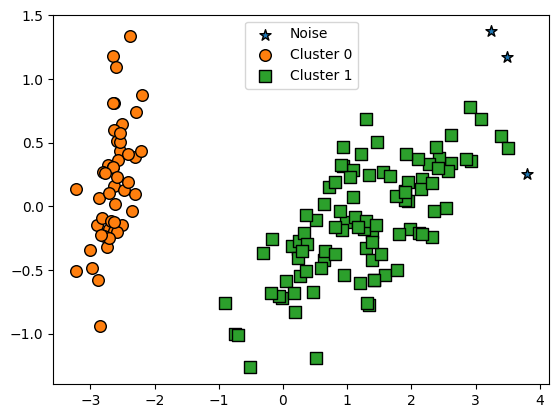

In [7]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster',iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


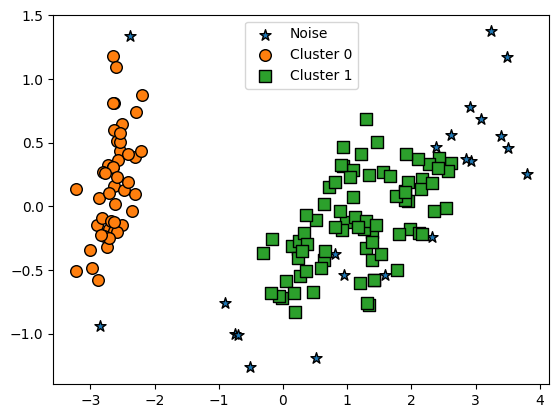

In [8]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)
visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

* make_circles() 데이터 세트 DBSCAN 적용

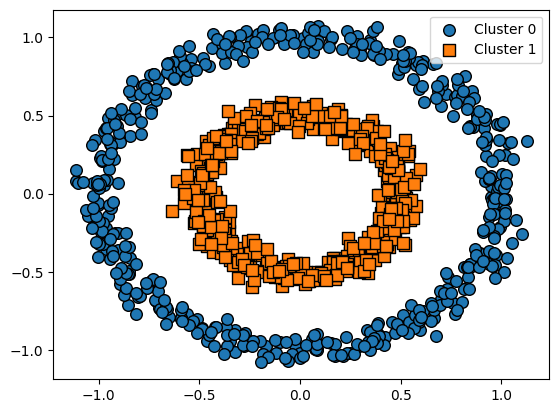

In [9]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1','ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

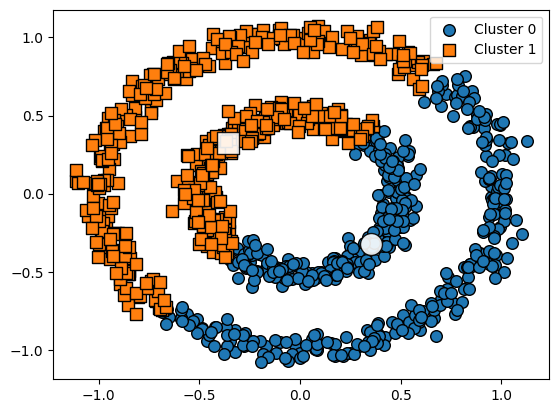

In [10]:
# K-평균 군집화 수행
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

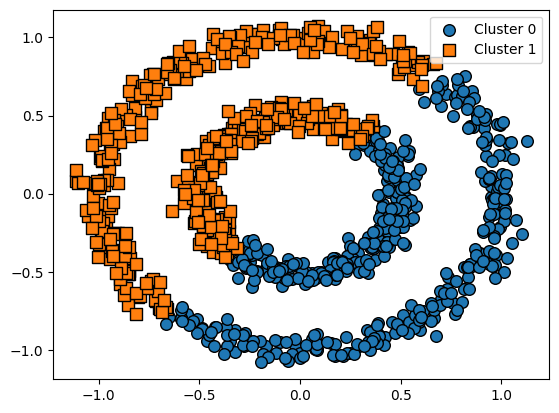

In [11]:
# GMM 군집화 수행
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

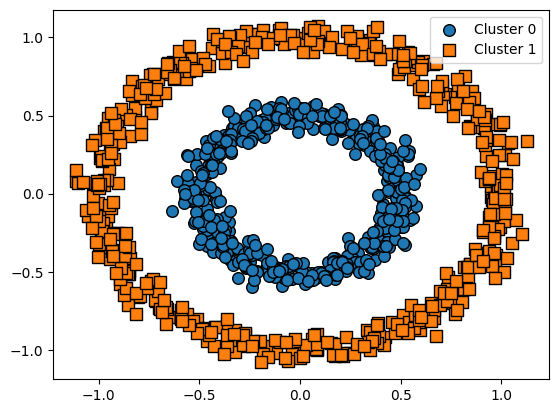

In [12]:
# DBSCAN 군집화 수행
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

* 고객 세그먼테이션 군집화 수행

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io="/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx")
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [17]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [18]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [19]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


In [20]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


In [21]:
retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)

In [22]:
# 상위 5개 주문 건수, 주문 금액 데이터 추출

print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [24]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

np.float64(1.028702077315023)

In [25]:
# 데이터 프레임의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations={
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monentary로 변경
cust_df = cust_df.rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'sale_amount':'Monetary'
})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [26]:
# Recency = 오늘 날짜 기준으로 가장 최근 주문 일자를 뺀 날짜

import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


* rfm 기반 고객 세그먼테이션 수행

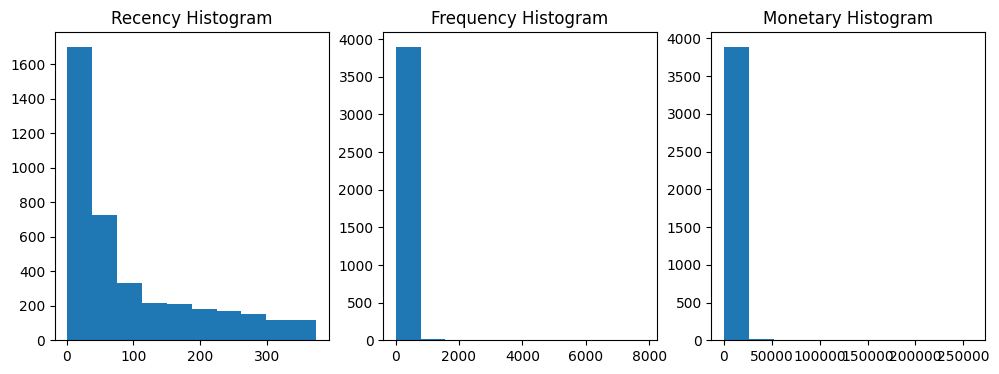

In [27]:
# 칼럼별 히스토그램 확인(왜곡된 분포 확인)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

In [29]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [30]:
# 표준화 후 K-평균 수행

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.576


In [31]:
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [32]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

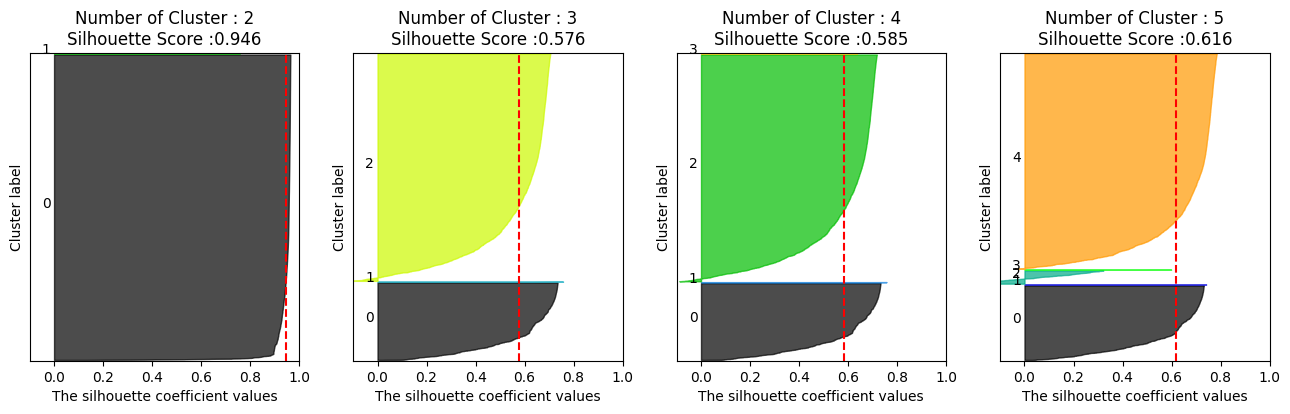

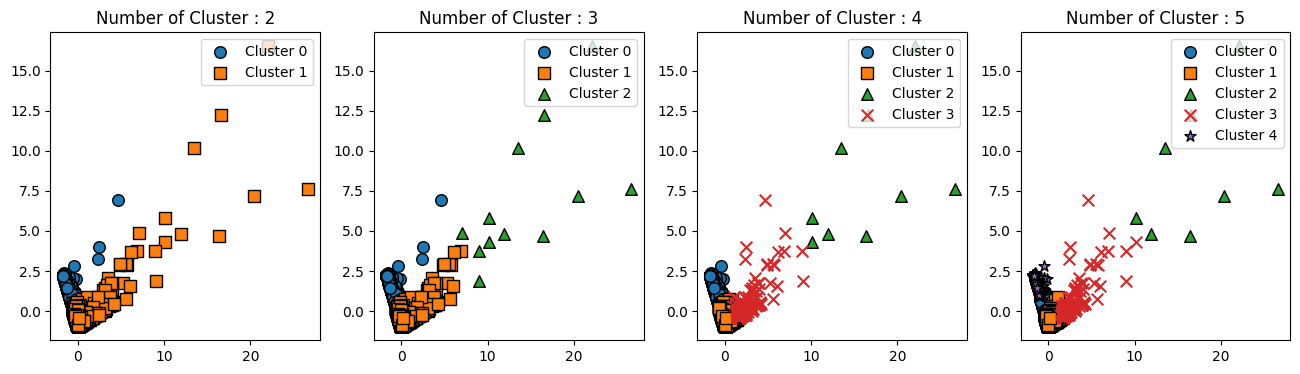

In [33]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

In [34]:
# 로그 변환 후 K-평균 수행

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# R,F,M 칼럼에 로그변환
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# 로그 변환 데이터에 StandardScaler 적용
X_features = np.log1p(cust_df[['Recency','Frequency','Monetary']].values)
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.303


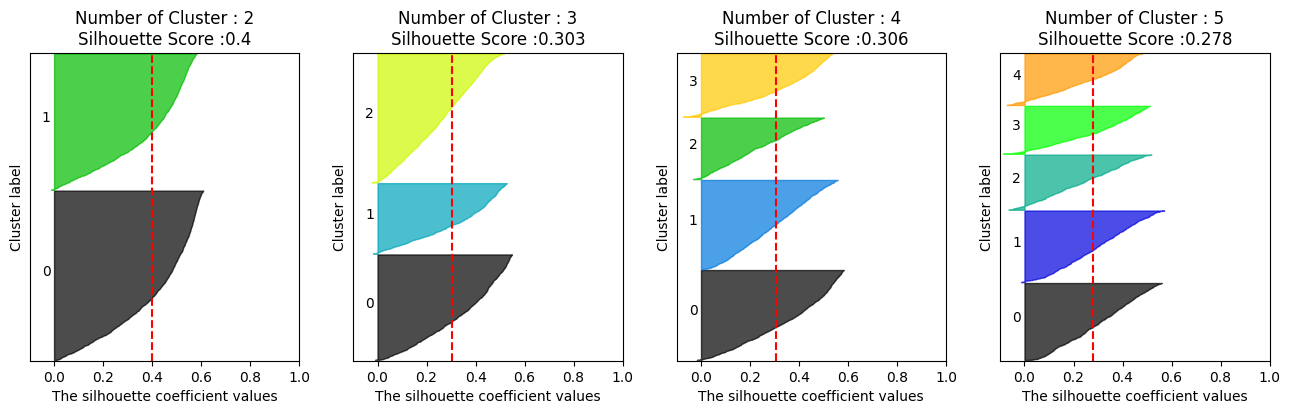

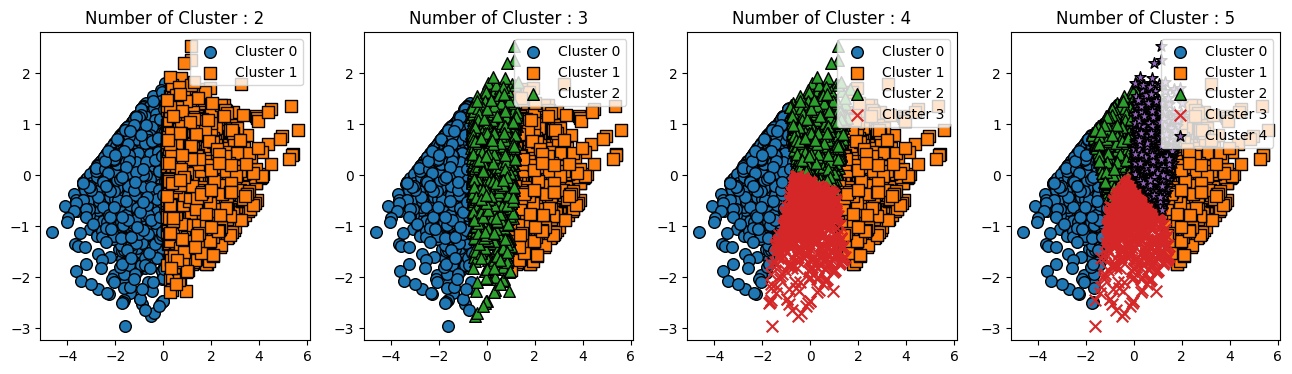

In [35]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)